In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

In [2]:
import geopy.distance

In [3]:
import re

In [4]:
import sqlite3
import pandas as pd

In [5]:
from bokeh.plotting import figure, output_file, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.models import ColumnDataSource
from pyproj import Proj, transform

# Pick an easy river

For starters I'm going to look at a single river at a time, and I'll start with an easy one. I expect a river will be easy to predict if:
 - it has a small catchment area. So the nearest rainfall station is pretty much represntative of all the rain that falls in the catchment
 - it has a small volume. So the river level will go up and down quickly in response to rainfall. 

Unfortunatly I don't (currently) have data about catchment size, and river volume, but I can take a guess  based off my own background knnowledge of the region. I would guess that maybe the Kangaroo river would be a good example for this, but lets have a look at its properties to check.

In [6]:
con = sqlite3.connect('./Data/mydb.db')
df_stations = pd.read_sql('SELECT * FROM Stations', con)
df_gauges = pd.read_sql('SELECT * FROM Gauges', con)
df_rainfall = pd.read_sql('SELECT * FROM Rainfall', con, index_col=['station_id', 'date'])
df_levels = pd.read_sql('SELECT * FROM Levels', con, index_col=['gauge_id', 'date'])

Allen river (barrington tops), Williams river (barrington tops), Bielsdown

In [7]:
df_gauges[df_gauges['name'].str.contains('Kangaroo')]

,id,name,lat,long,elev,NearestStat


In [8]:
df_gauges[df_gauges.id==215220]

,id,name,lat,long,elev,NearestStat


## Fetch raw data - hourly

hmmm, I seem to be missing data for the kangaroo river... I wonder why. For now I'll manually fetch the csv (from https://realtimedata.waternsw.com.au/) and I'll look into this problem later. 

In [9]:
df_levels = pd.read_csv('./Data/riverlevels/215220.csv')
df_levels = df_levels[['Time', '215220', 'Unnamed: 6']]
df_levels.columns = ['datetime', 'level', 'quality']
df_levels = df_levels.iloc[3:]
df_levels = df_levels.dropna()
df_levels['datetime'] = pd.to_datetime(df_levels['datetime'])
df_levels = df_levels.set_index('datetime')
df_levels['level'] = pd.to_numeric(df_levels['level'])

/home/jemma/anaconda3/envs/river_levels/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


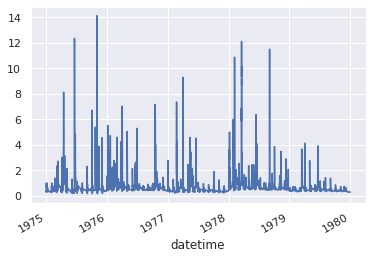

In [10]:
df_levels.loc['1975-01-01':'1980-01-01', 'level'].plot()

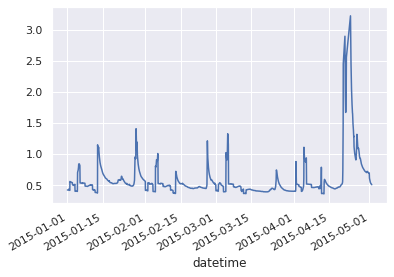

In [11]:
df_levels.loc['2015-01-01':'2015-05-01', 'level'].plot()

The kangaroo goes up and down a loooot! Much more than I would expect other rivers. Maybe the interesting points of this are around rainfall events, rather than around rising above minimum. 

## Rainfall

We have a lot of rainfall to stations to choose from. We want one which will tell us how much water is going into the kangaroo river. Lets see how well we can do by just looking at the nearest rainfall station.

Get the lat lon of the gauge at kangaroo. It's in the metadata in the river levels file which is culled on clean up. 

In [12]:
metadata = pd.read_csv('./Data/riverlevels/215220.csv', low_memory=False)['Unnamed: 7'][4]
display(metadata)

lat_lon_regex = '.* Lat:(?P<lat>[0-9\.-]*) Long:(?P<lon>[0-9\.-]*) .*'
lat_lon_regex_result = re.search(lat_lon_regex, metadata)
lat = float(lat_lon_regex_result.group('lat'))
lon = float(lat_lon_regex_result.group('lon'))
lat, lon

'215220 - KANGAROO RIVER AT HAMPDEN BRIDGE Lat:-34.72798991 Long:150.52244073 Elev:70m'

(-34.72798991, 150.52244073)

For each rainfall station, calculate its distance from our gauge. Pick the nearest.

In [13]:
def add_distances(lat, lon, df_stations):
    df_stations['dist'] = df_stations.apply(lambda x: geopy.distance.geodesic((lat, lon), (x.lat, x.long)).km, axis=1)
    return df_stations

def get_id_nth_nearest_station(lat, lon, df_stations, n):
    df_stations = add_distances(lat, lon, df_stations)
    return df_stations.sort_values('dist').iloc[n].id

nearest_station_id = get_id_nth_nearest_station(lat, lon, df_stations, 0)
df_stations[df_stations.id == nearest_station_id]

,id,name,opened_year,closed,lat,long,elev,state,dist
361,68136,BOMADERRY,1903,None,-34.85,150.62,8,NSW,16.215134


Now lets have a quick look at the how well the rainfall seems to match up with the river levels. We would expect to see every spike in river levels associated with a spike in rainfall. 

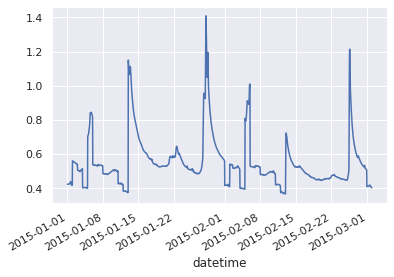

In [14]:
date_range = ('2015-01-01', '2015-03-01')
df_levels.loc[date_range[0]:date_range[1], 'level'].plot()

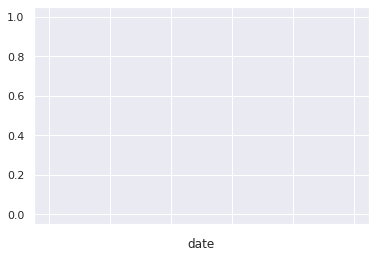

In [15]:
rainfall_kang = df_rainfall.loc[nearest_station_id]
rainfall_kang.loc[date_range[0]:date_range[1], 'rainfall'].plot()

Oh dear... this rainfall station has no data for this date range. That isn't going to be very useful. How about we try the next closest rainfall station. 

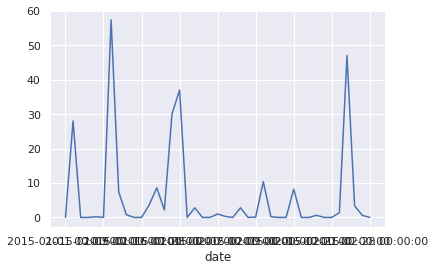

In [16]:
next_nearest_station_id = get_id_nth_nearest_station(lat, lon, df_stations, 1)
rainfall_kang = df_rainfall.loc[next_nearest_station_id]
rainfall_kang.loc[date_range[0]:date_range[1], 'rainfall'].plot()

This seems pretty good... Where is it though?

## Find a good gauge

Where are all our stations? Lets plot the nearby rainfall stations on a map to see what our cmhoices are...

In [17]:
def lon_lat_to_wm(lon, lat):
    wm_x, wm_y = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), lon, lat)  # longitude first, latitude second.
    return wm_x, wm_y

In [18]:
station_distances = add_distances(lat, lon, df_stations)
station_distances['wm_x'] = station_distances.apply(lambda x: lon_lat_to_wm(x.long, x.lat)[0], axis=1)
station_distances['wm_y'] = station_distances.apply(lambda x: lon_lat_to_wm(x.long, x.lat)[1], axis=1)
station_distances

,id,name,opened_year,closed,lat,long,elev,state,dist,wm_x,wm_y
0,46024,WILCANNIA (MURTEE),1923,None,-31.58,143.49,60,NSW,742.900632,1.597323e+07,-3.708304e+06
1,47019,MENINDEE POST OFFICE,1876,None,-32.39,142.42,61,NSW,795.526485,1.585412e+07,-3.814614e+06
2,47051,TANGRAMBALLY,1952,None,-34.50,143.67,-9999,NSW,628.856981,1.599327e+07,-4.096139e+06
3,47100,WENTWORTH LOCK 10 (MURRAY RIVER),1872,None,-34.11,141.90,-9999,NSW,795.361253,1.579624e+07,-4.043582e+06
4,48009,CARINDA (BOOROOMA),1881,None,-30.10,147.46,122,NSW,588.449269,1.641517e+07,-3.516410e+06
...,...,...,...,...,...,...,...,...,...,...,...
499,75128,WHEALBAH,1900,None,-33.72,145.30,-9999,NSW,493.957843,1.617472e+07,-3.991267e+06
500,75137,HAY (PEVENSEY),1967,None,-34.56,144.64,85,NSW,539.557507,1.610125e+07,-4.104247e+06
501,75157,THE CUBAS,1887,None,-33.87,144.88,94,NSW,528.012406,1.612797e+07,-4.011360e+06
502,75163,HILLSTON ( ALDINGA),1971,None,-33.35,145.87,135,NSW,455.941177,1.623817e+07,-3.941853e+06


In [19]:
output_file("tile.html")
tile_provider = get_provider(CARTODBPOSITRON)

# define our points in web mercator
wm_x, wm_y = lon_lat_to_wm(lon, lat)
rainfall_station_location = ColumnDataSource(station_distances)

# define the hover information
tooltips = [
    ('Name', '@name'),
    ('Distance from gauge', '@d_kang')
]

# range bounds supplied in web mercator coordinates
plot_size = 100000
x_range = (wm_x-plot_size/2, wm_x+plot_size/2)
y_range = (wm_y-plot_size/2, wm_y+plot_size/2)

# make the plot
p = figure(x_range=x_range, y_range=y_range, x_axis_type="mercator", y_axis_type="mercator", tooltips=tooltips)
p.add_tile(tile_provider)
p.circle(x=[wm_x], y=[wm_y], size=10, fill_color="red")
p.circle(x="wm_x", y="wm_y", size=15, fill_color="blue", fill_alpha=0.8, source=rainfall_station_location)

show(p)

OK, so none of the stations are particularly close, and none are on the plateu. So now we're choosing betweeen bad options. 

## Choose station based off correlation

To choose between the nearby stations, lets look at how well the rainfall levels correlate with the river level. I expect that the relationship will between rainfall and river level will be highly non-linear and incorporate some time delay. So to simplify this correlation, lets just look at how well 'its rained in the last 3 days' correlates with 'river is now above its median height'. So we don't care about the exact relationship between how much the river goes up with different amounts of rainfall (that will be a job for the actual model), what we're looking at here is whether this rainfall gauge is indicative of rainfall in the river's catchment. 

For starters, lets simplify the river level data. We want to extract whether or not the river was above its median on each day.

In [20]:
median_level = df_levels.level.median()

How often is the river above median? This approach is based off the assumption that its relatively rare. 

In [21]:
df_levels_max_daily = df_levels.groupby(df_levels.index.date).max()
df_levels_max_daily.index = pd.to_datetime(df_levels_max_daily.index)

In [22]:
n_days = len(df_levels_max_daily)
n_days_above_median = len(df_levels_max_daily[df_levels_max_daily['level']>median_level])
n_days_above_median / n_days

0.5270139309509388

And how often does it rain?

In [23]:
nearest_station_id = get_id_nth_nearest_station(lat, lon, df_stations, 1)
rainfall_at_nearest = df_rainfall.loc[nearest_station_id]
n_days = len(rainfall_at_nearest)
n_rainy_days = len(rainfall_at_nearest[rainfall_at_nearest.rainfall>0])
n_rainy_days/n_days

0.2892534464004262

### Merge gauge with nearby rainfall at given time

Match each river level with the rainfall of the previous day - at a particular gauge

In [76]:
def get_rainfall_at_station(df_rainfall, station_id):
    rainfall_at_nearest = df_rainfall.loc[station_id]
    rainfall_at_nearest.index = pd.to_datetime(rainfall_at_nearest.index)
    return rainfall_at_nearest

In [96]:
df_kang = df_levels_max_daily
nearest_station_ids = [get_id_nth_nearest_station(lat, lon, df_stations, i) for i in range(10)]
nearest_station_ids.append(get_id_nth_nearest_station(lat, lon, df_stations, -1))
for nth_nearest_station_id in nearest_station_ids:
    rainfall_at_nearest = get_rainfall_at_station(df_rainfall, nth_nearest_station_id)

    df_kang = pd.merge(df_kang, rainfall_at_nearest['rainfall'], left_index=True, right_index=True, how='left')
    df_kang = df_kang.rename(columns={'rainfall': nth_nearest_station_id})
df_kang

,level,68136,68003,68031,68168,68076,68154,70078,68166,70039,69049,48178
1973-01-12,0.837,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN
1973-02-12,0.747,NaN,9.9,NaN,8.6,3.3,NaN,NaN,2.8,4.6,4.8,NaN
1973-03-12,0.746,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN
1973-04-12,0.688,NaN,3.6,NaN,0.0,3.0,NaN,NaN,1.0,3.8,0.8,NaN
1973-05-12,0.861,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-04,0.447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-01,0.140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-02,1.918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-03,0.517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I think this'll be a good format to work with for checking which rainfall stations is best to use for this gauge. The index is the timestamp, so we're matching up observations with time. The river level has been selected for the max river level which occured that day since we had hourly data. Then for each of the rainfall stations of interest (close stations chosen here), we have a column of rainfall recorded at that station on that day.  

In [97]:
def plot_correlation_at_lags(df, station_id, max_lag):
    c = [df_kang['level'].corr(df_kang[station_id].shift(i)) for i in range(max_lag)]

    if not any([math.isnan(v) for v in c]):
        plt.plot(range(max_lag), c)

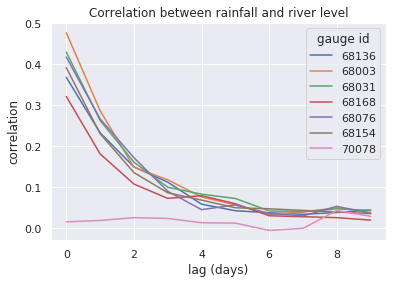

In [102]:
for nth_nearest_station_id in nearest_station_ids:
    plot_correlation_at_lags(df_kang, nth_nearest_station_id, 10)
plt.title("Correlation between rainfall and river level")
plt.xlabel("lag (days)")
plt.ylabel("correlation")
plt.legend(nearest_station_ids, title='gauge id')
plt.show()

Here we look at how well the rainfall correlates with the river level at different gauges, and with different amounts of lag. As we would expect for such a small volume (highly responsive) river, the best indicator of today's river level is today's rainfall. We also note that the correlation with rainfall stations which are nearby are all high relative to the one rainfall station which was chosen to be far away. 

Interestingly, the nearest rainfall station is not the most highly correlated. 

However, as we mentioned at the start of this section, correlation is not a great measure of the quality of the predictor for this relation becuuase we expect it is highly non-linear. 
Instead, what we were going to do was use 'it rained'/'it didn't rain' against 'river levels are high' or 'river levels are not high' and see how good the correlation is there. This will be a less nuanced measure, but should also have less noise due to differing shapes of the relationships.  